# "The masked analyst"
> "Fixing some data analysis problems in a paper on masks to highlight common pitfalls to avoid"

- toc: false
- badges: true
- comments: false
- categories: [data-science, covid19]
- hide: true
- search_exclude: false

## Background
We are going to review the paper [Effectiveness of Surgical and Cotton Masks in Blocking SARS–CoV-2: A Controlled Comparison in 4 Patients](https://annals.org/aim/fullarticle/2764367/effectiveness-surgical-cotton-masks-blocking-sars-cov-2-controlled-comparison) with a focus on the interpretation of the data.

> Warning: although we are going to nitpick the small report quite a lot, this is in no way an attack on the authors or their work. In fact I consider even this minute studies quite important given the current pandemic. Furthermore: there have been comments by several people about methodological mistakes in the study. I am in no position to comment on those. In fact I want to stress out that I am in no position of advising anybody on such a delicate topic except, maybe on how to avoid some common mistakes

Apart for a personal interest in the topic of masks for source control of the COVID-19 pandemic, the two main reasons that make this paper a good subject of examination are that
1. the study is so small that we can easily rewrite the whole dataset and tear it apart at our convenience
2. it highlights a number of common pitfalls when interpreting/analysing data that any person working with data should be aware of

The goal of the paper, as stated by the authors themselves is

> To evaluate the effectiveness of surgical and cotton masks in filtering SARS–CoV-2.

In order to do that, they selected 4 patients with COVID-19 and had them cough on a petri dish kept 20 cm away, first without a mask, then with a surgical mask, then with a cotton mask, and finally a second time without a mask. After that, both the petri dishes and the masks were examined to measure the concentration of virus particles.

The data gathered is all contained in this small table

![](masks/data_table.jpg)

In [2]:
#hide

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Reproducing the analysis

As I said, the amount of data gathered is so small that we can easily rewrite it by hand and peruse it. Since I am less interested in the mask surfaces measurements, I will leave those numbers out, especially considering that they look quite bizarre (there are a number of possible explanations for the inner side of the masks having way lower concentrations of virus particles than the outer side, but they are way beyond my understanding and scope for this post). 

In [3]:
#collapse

naso_pha_swab = [7.68, 5.42, 5.98, 3.57]
saliva_swab = [4.29, 2.59, 5.91, 3.51]
control1 = [3.53, 2.14, 2.52, np.nan]
surgical_mask = [3.26, 1.8, 2.21, np.nan]
cotton_mask = [2.27, np.nan, 1.42, np.nan]
control2 = [3.23, 2.06, 2.64, 2.44]

data_df = pd.DataFrame(data=[naso_pha_swab, saliva_swab, control1, control2, surgical_mask, cotton_mask], 
             columns=['patient1', 'patient2', 'patient3', 'patient4'],
             index=['np_swab', 'saliva_swab', 'control_before', 'control_after', 'surgical_mask', 'cotton_mask']).T

data_df

,np_swab,saliva_swab,control_before,control_after,surgical_mask,cotton_mask
patient1,7.68,4.29,3.53,3.23,3.26,2.27
patient2,5.42,2.59,2.14,2.06,1.80,NaN
patient3,5.98,5.91,2.52,2.64,2.21,1.42
patient4,3.57,3.51,NaN,2.44,NaN,NaN


### Problem 1: Basic sanity check

There is very little in terms of description of how the data analysis has been performed. This is what I can find in the paper.

> The median viral loads of nasopharyngeal and saliva samples from the 4 participants were 5.66 log copies/mL and 4.00 log copies/mL, respectively. The median viral loads after coughs without a mask, with a surgical mask, and with a cotton mask were 2.56 log copies/mL, 2.42 log copies/mL, and 1.85 log copies/mL, respectively. 

Unfortunately, if we try and reproduce those numbers we get something very different

In [4]:
data_df.median().round(2)

np_swab           5.70
saliva_swab       3.90
control_before    2.52
control_after     2.54
surgical_mask     2.21
cotton_mask       1.84
dtype: float64

**Solution: read the comments section**

Reading the [comments section](https://annals.org/aim/fullarticle/2764367/effectiveness-surgical-cotton-masks-blocking-sars-cov-2-controlled-comparison) of the paper, we discover that not only the authors meant mean, rather than median, but there is also a typo in the average control viral load. This is what they state the paragraph above should read:

> The mean viral loads of nasopharyngeal and saliva samples from 4 participants were 5.66 log copies/mL and 4.00 log copies/mL, respectively, when we did calculate not detectable values. The mean viral loads after coughs without a mask, with a surgical mask, and with a cotton mask were 2.65 log copies/mL, 2.42 log copies/mL, and 1.85 log copies/ml, respectively, when we did not calculate not detectable values

If we check the mean rather than median, we get way closer numbers. I am still a bit uncertain about the saliva swabs mean viral load, but the other differences can definitely be attributed to rounding problems

In [5]:
data_df.mean().round(2)

np_swab           5.66
saliva_swab       4.07
control_before    2.73
control_after     2.59
surgical_mask     2.42
cotton_mask       1.84
dtype: float64

Taking the average of the two control means, we also get a number which is quite close to the stated control viral load.

In [6]:
def get_control(df): return( df['control_before'] + df['control_after']) / 2
get_control(data_df.mean().round(2)).mean()

2.66

> Important: Always double check your numbers and do frequent sanity checks

### Aside: Median or Mean?

Although after the authors' corrections the topic is not strictly relevant to our analysis, how can we decide whether to pick the median or the mean as a centrality measure? 

The quick answer is that it is almost always a good idea to use the median rather than the mean, as it is way more robust to outliers (for a more detailed explanation you can check, for example, [this post](https://creativemaths.net/blog/median/)). The reason why we tend to use the mean is that it is mathematically well behaved and efficient to compute, but nowadays we can get around that with brute computational power and get something which is more robust. 

The main exception to this rule is when you have very small samples, especially if you are measuring integers. The reason being that in this situation the median can jump around quite a bit. Let's run a small experiment. Here is a population of 20,000 integeres normally distributed (with standard deviation 20) around a mean of 100.

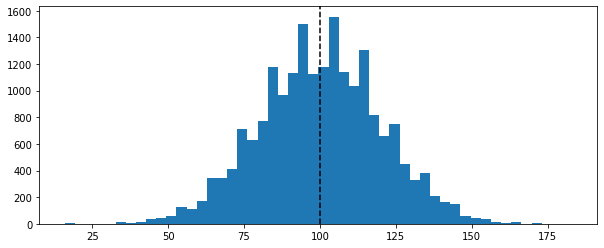

In [7]:
#collapse

population = np.random.normal(100, 20, 20000).round().astype(int)
plt.subplots(figsize=(10, 4))
plt.hist(population, bins=50)[-1]
plt.axvline(population.mean(), color='k', linestyle = '--');


If we draw 1000 random samples of size 4 from the population, we can see that the medians of the samples are a bit more spread out than the means (and have a higher standard deviation). This means that picking the median we are more likely to make of being further away from the true population statistics. 

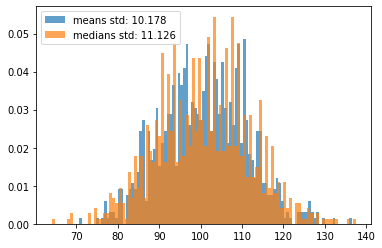

In [8]:
#collapse
samples = [np.random.choice(population, replace=False, size=4) for _ in range(1000)]
medians = [np.median(x) for x in samples]
means =  [np.mean(x) for x in samples]

plt.hist(means, bins=100,  density=True, alpha=.7, label=f'means std: {round(np.std(means), 3)}')[-1]
plt.hist(medians, bins=100, density=True, alpha=.7, label=f'medians std: {round(np.std(medians), 3)}')[-1]
plt.legend();

> Important: prefer the median over the mean, except when dealing with very small samples of integers.

In fact, this is exactly the situation of the paper we are looking at (the reason will be probably clearer when we get to the discussion on the units of viral loads).

### Conclusions (of the paper)

With those numbers we have seen above in mind, the authors reach the conclusion that surgical and cotton masks are not effective at controlling the spread of COVID-19:

> Neither surgical nor cotton masks effectively filtered SARS–CoV-2 during coughs by infected patients [...] In conclusion, both surgical and cotton masks seem to be ineffective in preventing the dissemination of SARS–CoV-2 from the coughs of patients with COVID-19 to the environment and external mask surface.

Although they do not specify any detail, we can see that the difference in percentage of the viral load with and without a mask is roughly 9% and 30% for surgical and cotton masks respectively, which seem to support that the conclusion that these kind of masks are barely useful.

In [9]:
def get_test(df): return(df[['surgical_mask', 'cotton_mask']])
def get_difference(df, pct=True): 
    return (get_control(df) - get_test(df).T) / get_control(df) if pct else (get_control(df) - get_test(df).T)

get_difference(data_df.mean().round(2))

surgical_mask    0.090226
cotton_mask      0.308271
dtype: float64

End of the story then? 

Not exactly.

### Problem n.2: ND != NA

As I am sure everybody who has dabbed a bit with data science knows, one of the common themes when doing exploratory data analysis and preparing your dataset is dealing (and inputing) missing values. There are different ways of dealing with them, but the most common ones are:

1. input some centrality measure to fill the missing values (normally you want to use the median for continuous variable and the mode for categorical values)
2. build a predictive model to fill the gaps and use the predictions insted
3. throw away the missing values altogether

The last one is usually the safest option, and it is what we have done so far (when we computed the mean the default behaviour is simply ignore missing values), and I assume this is what the authors mean by 

> when we did not calculate not detectable values

If you check the table at the beginning of the post, though, you will see that `ND` stands, in fact, for "not detected".

The problem here is that "not detected" does not mean that the value is missing: it means that it is too low for us to measure it. This means, in principle, that, depending on how sensitive the measure is, it could be anywhere between 0 and 1.42 (which is the smallest value measured in the table).

Let's see what happens if we consider 1.41, which is the most conservative value for the detectability threshold. 

In [10]:
data_df.fillna(1.41).mean().round(2) 

np_swab           5.66
saliva_swab       4.07
control_before    2.40
control_after     2.59
surgical_mask     2.17
cotton_mask       1.63
dtype: float64

In [11]:
get_control(data_df.fillna(1.41).mean().round(2))

2.495

In [12]:
get_difference(data_df.fillna(1.41).mean().round(2))

surgical_mask    0.130261
cotton_mask      0.346693
dtype: float64

As we can see, even if the end result still seems to indicate that cotton and surgical masks are not particularly effective at source control, the numbers (especially for surgical masks) have changed quite a bit.

> Important: pay particular attention at the semantics of unusual values. This includes missing values and outliers (for example, it is not uncommon to use "magic" dates or numbers to indicate a missing value or something specific about a piece of data). If you do not, it might completely throw off your analysis

### Problem n.3: wrong test

Another problem of the approach we have used so far is that the authors are (presumably) comparing the average viral loads of the same group with and without the masks. This (i.e. evaluating the differences of the averages) is the same as considering the test and control groups as independent, which is certainly not the case here as it's the same patients being used as test and control groups. A more appropriate idea is to instead consider the differences with and without the masks for each patient independently and then averaging those differences. *In other words, it is better to compute the mean of the differences rather than the difference of the mean*. This is particularly important when there is a lot of variance in your test population. It is hard to tell in this case, but looking at the characteristic of the patients, they are far from a homogeneous group. Furthermore, there is really no reason not to use the appropriate test, so let's see what happens.

In [13]:
get_difference(data_df.fillna(1.41)).T

,surgical_mask,cotton_mask
patient1,0.035503,0.328402
patient2,0.142857,0.328571
patient3,0.143411,0.449612
patient4,0.267532,0.267532


In [14]:
get_difference(data_df.fillna(1.41)).T.mean()

surgical_mask    0.147326
cotton_mask      0.343530
dtype: float64

In this case not much has changed (except that surgical masks look slightly better than before).

> Important: check your assumptions of indpendence betweeen the test and control groups (you have a test and control group, right?)

### Huge Problem n.4: watch your logs!

If we look carefully at the data table from the paper, we notice that there is no unit to tell us what are the numbers we are measuring. This can be found in the text though (and it is probably obvious to anyone who is used to deal with viral loads):

> The median viral loads of nasopharyngeal and saliva samples from the 4 participants were 5.66 log copies/mL and 4.00 log copies/mL, respectively.

Here we notice a red flag: `log copies/mL` seems to indicate that we are dealing with a logarithmic scale. A quick googling can confirm that: those numbers are the base 10 logarithm of the number of viral copies per milliliter. This is quite common when you are dealing with concentrations (the same thing happens, for example with [pH](https://en.wikipedia.org/wiki/PH), which is a measure of concentration of ions) as the numbers tend to be quite large and we are more interested in the _order of magnitude_ rather than the magnitude (i.e. the actual numbers) itself.

This causes a massive problem, though: when we take the mean of two logarithms, we are actually taking the [geometric mean](https://en.wikipedia.org/wiki/Geometric_mean) of the underlying quantities, and if we consider the difference of two logarithms, we are actually looking at the ratio of the quantities. 

Just in case you need a reminder for the properties of logarithms, what we are saying is that:

$$ (\log x + \log y) / 2 = \log { \sqrt {xy} } $$


How big of a problem this is? 

Consider this: a difference between two viral loads of 1 log copies/mL means that the larger load contains _10 times_ more viral particles than the smaller ones. If the two viral loads were 3 and 4 log copies/mL we would be treating a 90% difference as if it were a 25% difference. And if the two viral loads are 9 and 10 log copies/mL, we would be treating a 90% difference as if it were a 10% difference!

As a mathematician, my instinct would be to rewrite the formulas using the properties of the logarithms (which can be a pain or not necessarily possible), but in fact, especially when the range of values is relatively small, the easiest way to proceed is to "unroll" the logarithms and redo our computations with the actual quantities:

In [15]:
get_difference((10 ** data_df.fillna(1.41)), pct=False).T

,surgical_mask,cotton_mask
patient1,723.641748,2357.133893
patient2,63.331160,100.722936
patient3,221.642467,357.520797
patient4,124.859456,124.859456


In [16]:
get_difference((10 ** data_df.fillna(1.41)), pct=False).T.mean()

surgical_mask    283.368708
cotton_mask      735.059271
dtype: float64

These are the average number of viral particles filtered. How does this compare with the numbers computed before we unrolled the logarithms? It's roughly 100 times larger.

In [17]:
10 ** get_difference(data_df.fillna(1.41), pct=False).T.mean()

surgical_mask    2.119581
cotton_mask      7.391796
dtype: float64

So, all in al,l once we have fixed all the problems these are the filtering powers of surgical and cotton masks under our (conservative) look like this:

In [18]:
get_difference((10 ** data_df.fillna(1.41)), pct=True).T.mean()

surgical_mask    0.548049
cotton_mask      0.871057
dtype: float64

This is a very different result from what we have obtained above as it seems to suggest that cotton masks are actually quite good at reducing the viral load spread (and remember that we are talking about coughing and being 20 cm apart, in reality this might have huge impact on the effectivness of social distancing). 

> Important: always check the units and be very cautious when using a logarithmic quantity. Try to "unroll" the log before doing your computations if the range is not too large.

So far I hope you are convinced that the conclusions reached in the paper is, at the very least, not that clear cut (and if you ask me in fact it's the exact opposite of what the data is actually saying). 

But let's address a further criticism that is very often used to dismiss small studies.

### Statistical significance

"Surely an experiment with `N = 4` is not statistically significant" or something along those lines is a sentence that I hear far too often when evaluating the effort needed to measure an imporant quantity. Well, it turns out that until you start designing experiments and actually look at the numbers, we don't really have an intuitive feel for sample sizes.

Let's see what we can do here. The first and most important problem we have is that the objective of the study is actually not well defined.

> To evaluate the effectiveness of surgical and cotton masks in filtering SARS–CoV-2.

As data people we should always make sure that the question we are trying to answer is well defined from a quantitative point of view, and this particular one is not (what does "effective" means in this context)? Furhtermore, the experiment is, not designed to test how effective masks are, for example, at filtering the virus in case of people, talking, or sneezing, or even just breathing, which would be interesting for advising policies in this case.

Keeping in mind that we are deviating from the original objective of the study, let's see if we can formulate some question that we can try and answer with the data available.

> Warning: let me state this clearly. In general, fishing for questions _after_ the experiment is a **very bad idea** and it is not how you design an experiment. This is just an exercise in measuring what can be achieved with small samples and would give us a good idea of how to design a proper study

These are (by patient) the reductions of viral loads in percentage between our test and control conditions:

In [19]:
eff_pcts = get_difference((10 ** data_df.fillna(1.41))).T ; eff_pcts

,surgical_mask,cotton_mask
patient1,0.284524,0.926786
patient2,0.500931,0.796689
patient3,0.577459,0.931472
patient4,0.829282,0.829282


Let's start with a very simple question: are masks better than nothing at reducing the viral load (under the test conditions)?

To appease the frequentist readers, let's do a very basic [t-test](https://en.wikipedia.org/wiki/Student%27s_t-test). We will do it by hand, rather than using a specific library, except for the computation of the critical thresholds.

Our question translates into "is the filtered percentage of the viral load statistically greater than 0?" Here is is how we compute the t stats.

In [20]:
means = eff_pcts.mean()
### Notice: this is the standard error for N = 4
std_errors = eff_pcts.std() / 2
t_stats = means / std_errors

We use `scipy` to find the critical thresholds for $\alpha$ at 0.0625, 0.05, 0.01, and 0.005. In other word we compute the value above which the t-stats need to be in order for the p-value to be below the different $\alpha$ levels and for us to reject the null hypothesis that the test condition is not better than the control condition.

Why and whether this is a good idea is a very long and out of scope discussion, but this is a classical and radicated method of testing hypothesis. Except for the 0.0625 one which I will explain later, the values of $\alpha$ are some of the commonly used ones in science, with 0.05 being by far the most common.

In [21]:
from scipy.stats.distributions import t
αs = [0.0625, 0.05, 0.01, 0.005]
df = 3
for α in αs: print(f'{(α) * 100}%: {t.ppf(1 - α, df)}')

6.25%: 2.113086729236424
5.0%: 2.3533634348018264
1.0%: 4.540702858698419
0.5%: 5.84090929975643


So are the t statistics higher than those values? Let's see

In [22]:
t_stats

surgical_mask     4.875605
cotton_mask      25.473360
dtype: float64

It turns out that both cotton and surgical masks are better than no mask in a strongly statistically significant way. Cotton masks in particular have a p-value which is way lower than the strictest normally used significance thresholds.

In retrospect, though, the results is not surprising: given what we know about the virus transmission it is (or should be) common sense that putting a physical barrier in front of your mount will filter at least minimally better than not putting it. And in fact I claim that this should have been our null hypothesis in the first place, but let's not delve into that. Let's assume that in order for masks to be effective, they need to be filtering at least 80% of the viral load. Can we say that?

In [23]:
means = (eff_pcts - .8).mean()
std_errors = eff_pcts.std() / 2

# Let's directly see the p-vaues rather than the t-stats
(means / std_errors).apply(lambda x: 1 - t.cdf(x, df=df))

surgical_mask    0.944593
cotton_mask      0.064624
dtype: float64

Not surprisingly, the answer is a resounding no for surgical masks (but at this point they were not even in the game anymore). 

What about cotton masks? We have a p-value of 6.5%. This is above all the thresholds so in principle we cannot reject the null hypothesis, but it would be considered "at the border of significance" if we were to submit a paper. 

> Important: Even a very small sample can be statistically significant. In fact samples that are too large might have worse descriptive power, as they might amplify any sampling bias we have.

Let's think for a second about the values we have just seen. A p-value of 6.5% means that the average cotton mask could, in principle, not have a filtering power better than 80% as the p-value is not lower than the accepted 0.05 threshold (or any of the other thresholds we have looked at, for that matters). 

So we should not advice wearing cotton masks, right? Well not so fast: the p-value can be thought as the fals positive rate. This means that if we see an effect (like we do in this case, as the average in our sample is over 80%) the p-value is the probability of that effect being a statistical fluke. In other words, there is a 93.5% probability that the effect we are seeing (the average filtering power is higher than 80%) is real. 

Is this enough? It depends. In particular it depends on the cost of making a mistake. In most business cases, and when the cost of getting that wrong is very low, we can accept a false positive risk way higher than the standard 5% used in science.

> Important: There is nothing magic about the 5% statistical significance threshold. If you are doing hypothesis testing, pick a threshold that makes sense from a business perspective and consider the costs of making a mistake.

Let's do one last test before looking at a different trick. The question we want to answer is: are the averages filtering power of masks significantly better than the lowest values we have observed (with a weird significance threshold of 6.25%)?

In [24]:
means = (eff_pcts - eff_pcts.min()).mean()
### Notice: this is the standard error for N = 4
std_errors = eff_pcts.std() / 2
t_stats = means / std_errors
cohen_d = t_stats / 2
t_stats.apply(lambda x: 1 - t.cdf(x, df=df))

surgical_mask    0.050409
cotton_mask      0.058960
dtype: float64

Under this conditions we can reject the null hypothesis, so we can tell that the mean filtering power higher than the smallest number observed with a probability of at least 93.75% (1 - $\alpha$). Let's keep this in mind and see as later we will compare it to another technique.

> Warning: doing multiple experiments with the same observations and the same $\alpha$ values is in general a very [bad idea](https://xkcd.com/882/). Normally we would need to apply something like the [Bonferroni correction](https://en.wikipedia.org/wiki/Bonferroni_correction) or similar tricks. In this case, though, we are not really doing multiple experiments, but rather checking the same thing with different thresholds and probing for statistical significance, which we could have done analytically in a single go. In any case, please always be extra cautious with p-values. 

### A touch of Bayes

Hypothesis testing is all fun and good, but what if we wanted to answer a question like "how much viral load on average a cotton mask filters"? 

At this point we are out of the world of yes/no questions and we are into the world of measurement. In a certain Bayesian way of thinking, we could say that measuring something means reducing our uncertainty about the real value of that something. A good measurement consists in a range of possible values for the things we are measuring (since no measurement is without error) and a probability of the measured value to fall into that range. Essentially, the smaller the range (everything else being the same), the less our uncertainty. Measuring something, thus, means reducing the range of values we are confident enough our true value falls into.

One often overlooked aspect of measuring stuff (that with this very broad definition might also mean producing a report) is that each measurement has cost attached and a steeply diminishing value. 

For example, it is extremely easy to measure my height with a .5 meters precision. Still easy with a 10 cm precision. Reasonably doable within a 1 cm. Virtually impossible and probably very expensive within a 1 $\mu m$. Not to mention completely useless.

For this very reason, when we have a lot of uncertainty about a certain quantity, a very small number of measurement can take us a very long way.

In this perspective, since a priori we know nothing about the actual value of the filtering power of cotton masks for viral loads of SARS–CoV-2, we can expect to gain a lot of insight even with the very small number of measurments we have. 

Let's see this in practice. This is what we have measured (with the conservative assumption we are keeping about non detectable values).

In [25]:
eff_pcts = get_difference((10 ** data_df.fillna(1.41))).T.sort_values('cotton_mask')
eff_pcts.sort_values('cotton_mask').cotton_mask

patient2    0.796689
patient4    0.829282
patient1    0.926786
patient3    0.931472
Name: cotton_mask, dtype: float64

Once again, although it is not evident, "how much viral load on average a cotton mask filters" is not particularly well defined from a quantitative point of view. Let's rephrase it as "what is the median percentage of virus load filtered by cotton masks?".

Now, that's different. One of the hidden assumptions that we used during our hypotheses testing, which is almost inescapable, is that the sample we chose is not biased. In other words, we assume have selected our patients at random. This is essentially never true, and the bigger the sample, the worst the bias will be, but for the sake of argument, let's assume that the effect of sampling bias is negligible. In this case each measurement has a 50% probability of being below the median (by definition of median itself). With a bit of combinatorics, we can compute the probability of being higher than our highest measured value, our second highest value and so on.

In [26]:
np.array([1/16, 4/16, 6/16, 4/16, 1/16]).cumsum()[:-1]

array([0.0625, 0.3125, 0.6875, 0.9375])

What we are saying is that the median filtering power of cotton masks has a 6.25% chance of being above 93%, a 31.25% of being above 92.7%, etc.

In other word, with only 4 values we can assert that the median is higher than the smallest measured value with 93.75% probability. And this is true no matter how the values of filtering powers are distributed.

If we add some very common assumptions that we have used under the hood in our t-tests (namely that the median and the mean are the same), we can say exactly the same for the mean.

The combinatorics behind it are beyond the scope of this post (but not complicated), but as a general rule, if we sample (measure) N values from _any_ distribution, the probability that the median of the population (i.e. the "real" median) is higher than the smallest value we have measured is $$ 1 - \frac {1} {2 ^ N}$$

Notice that this is very close to the result we have obtained with the last t-test (so I hope now you understand the $\alpha$ value of 0.0625), but is stronger, since it is making fewer assumptions on the population and it only requires (at most) pen and paper and a quick calculation.

> Important: when uncertainty is large, you can get a lot of mileage from a very small sample.

### Quick power analysis



There is one last aspect that we have not eviscerated yet. Let's consider once again our t-test of significance for cotton masks being more than 80% effective on average. 

We already know that the p-value is above the $\alpha$ value of 0.05, so we cannot reject the null hypothesis. But does this mean that we have to reject the test hypotesis?

This is where the power come into play (or rather 1 minus the statistical power of the experiment). 

Like $\alpha$ is the acceptable risk of a false positive, there is an analogous $\beta$, which is the acceptable risk of a false negative. For some arbitrary historical reason, like we usually consider $\alpha$ to be 0.05, we consider $\beta$ to be 0.2. So the usually acceptable power of an experiment tends to be chosen as 1 - $\beta$, or 0.8. This means that _in case we cannot reject the null hypothesis_ we want the probability of the null hypothesis being true at least 80%.

The statistical power is not easy to compute manually, but can it done analytically for a t-test, so we will use the `statsmodels` library to do so. This works allows us to fix 3 values among power, the number of observations (the parameter `nobs`), the chosen $\alpha$ and the effect size (long story short, in the case of the t-test is the t statistic divided by the square root of the number of observations) in order to obtain the remaining one.

What's the power of our t-test?

In [27]:
means = (eff_pcts - .8).mean()
### Notice: this is the standard error for N = 4
std_errors = eff_pcts.std() / 2
t_stats = means / std_errors
cohen_d = t_stats / 2
t_stats.apply(lambda x: 1 - t.cdf(x, df=df))


from statsmodels.stats.power import TTestPower
TTestPower().solve_power(effect_size=cohen_d.cotton_mask, power=None, 
                             nobs=4, alpha=0.05, alternative='larger')

0.48376788050332065

A power of 48.4% (way below the acceptable 80% threshold) means that although we cannot reject the null hypothesis, there is still a 52% risk of being in presence of a false negative, which is not acceptable. So we cannot formally reject the test hypothesis either.

We have gained a new piece of information with our experiment, though: we are now able to guess the expected effect size if we were to repeat the experiment. And we can plug this into the power analysis to find out how many patients do we need to test in order to have an acceptable statistical power and confidence.

In [28]:
TTestPower().solve_power(effect_size=cohen_d.cotton_mask, power=.8, 
                             nobs=None, alpha=0.05, alternative='larger')

7.284382863086592

What this is telling us is that the difference between what we have observed for cotton masks and a filtering power of 80% of the viral load is so strong that we only need 8 people to design a new experiment that would give us a reasonable opportunity of either rejecting the null hypothesis with 95% oconfidence or rejecting the test hypothesis with 80% confidence.

As menitoned above: we tend not to have a good intuition of what good sample sizes are.

> Important: a very small and potentially quick study can help a lot in designing a proper statistically sound experiment. This is particularly useful for A/B testing, for example